In [2]:
%load_ext autoreload
%autoreload 2
%cd /mnt/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from src.visualization.show_image import show_image
from src.register_datasets import register_datasets, get_dataset_name
from src.config_builder import get_config


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/mnt/activeCell-ACDC
README.md    data		nohup.out	  requirements.txt  wandb
ac_acdc_env  jupyter_notebooks	output		  shell_scripts
al_output    log		pipeline_configs  src
/mnt/activeCell-ACDC/src


In [3]:
register_datasets()
ds_json = DatasetCatalog.get(get_dataset_name(
    ACDC_LARGE, DATASETS_DSPLITS[ACDC_LARGE][0]
))
running_on_server = False
print("running on server:", running_on_server)
cfg = get_config("acdc_large_al")
cfg.OUTPUT_DIR = "./al_output/acdc_large_al"
cfg.AL.OBJECT_TO_IMG_AGG = "mean"
mc_trainer = ActiveLearningTrainer(cfg, is_test_mode=not running_on_server)

wandb.init(
    project="activeCell-ACDC",
    name="",
    sync_tensorboard=True,
    mode="disabled",
)

mc_trainer.cfg.AL.DATASETS.TRAIN_UNLABELED = get_dataset_name(
    ACDC_LARGE, DATASETS_DSPLITS[ACDC_LARGE][0]
)
mc_trainer.al_dataset = ActiveLearingDataset(mc_trainer.cfg)
mc_trainer.query_strategy = MCDropoutSampler(mc_trainer.cfg)


registering acdc_small dataset
registering acdc_large dataset
registering acdc_large_cls dataset
running on server: False


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


registering acdc_small dataset
registering acdc_large dataset
registering acdc_large_cls dataset
[02/16 11:27:38 d2.data.datasets.coco]: Loading /mnt/activeCell-ACDC/data/acdc_large/train/cell_acdc_coco_ds.json takes 6.25 seconds.
WARNING [02/16 11:27:38 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/16 11:27:38 d2.data.datasets.coco]: Loaded 5803 images in COCO format from /mnt/activeCell-ACDC/data/acdc_large/train/cell_acdc_coco_ds.json
update_labeled_data


In [24]:
augs = [
        #T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
        #T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
        T.RandomRotation((0,360), expand=False),
        T.RandomBrightness(0.5, 2),
        T.RandomContrast(0.5, 2),
        T.RandomSaturation(0.5, 2),
        T.ResizeShortestEdge(
            short_edge_length=cfg.INPUT.MIN_SIZE_TRAIN,
            max_size=cfg.INPUT.MAX_SIZE_TRAIN,
            sample_style=cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING,
        ),
    ]

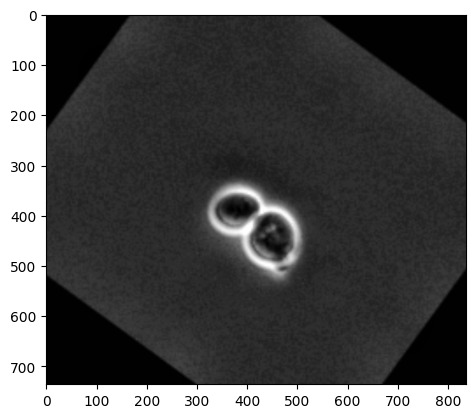

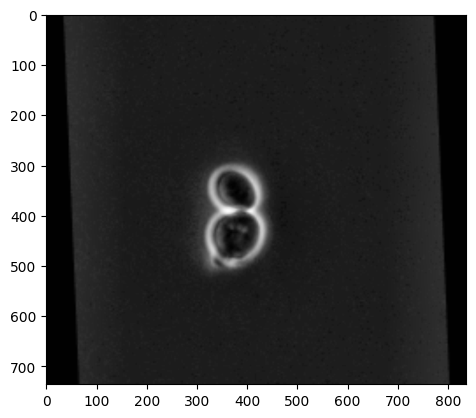

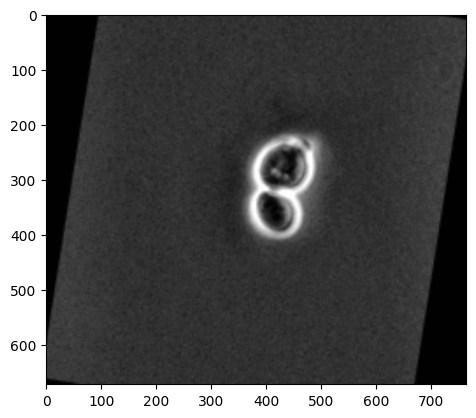

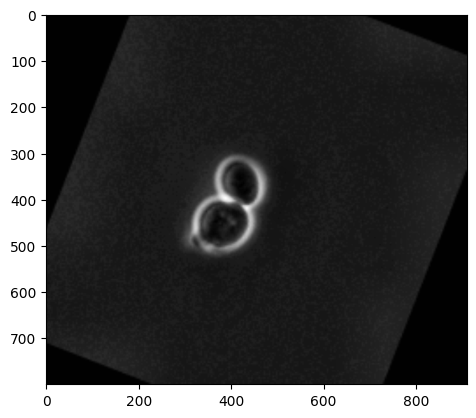

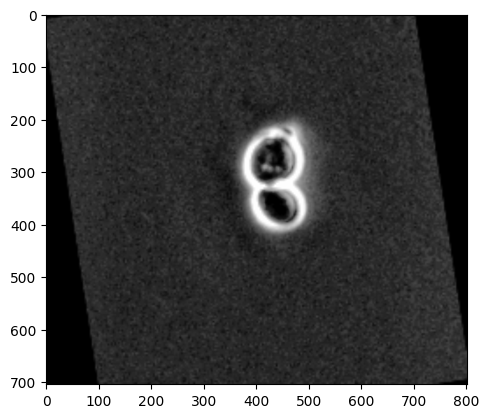

In [25]:
def show_augs(augs, input_image):
    
    for aug in augs:
        print(aug)
        show_multiple_ims_per_aug(aug, input_image)
        
def show_multiple_ims_per_aug(aug, input_image):
    imgs = []
    for _ in range(5):
        image = aug.get_transform(input_image).apply_image(input_image)
        imgs.append(image)
    show_image(imgs)
    
#show_augs(augs)

def apply_augs(augs, image):
    for aug in augs:
        image = aug.get_transform(image).apply_image(image)
    return image

im_json = ds_json[0]
input_image = cv2.imread(im_json["file_name"])
for _ in range(5):
    show_image(apply_augs(augs, input_image))

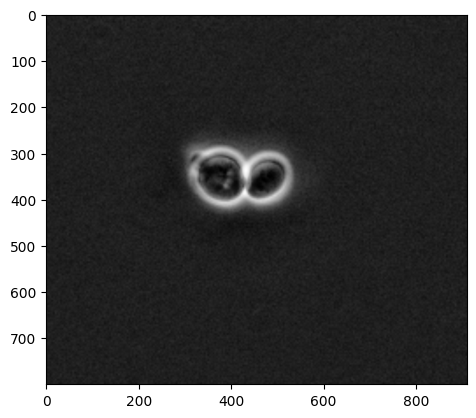

In [8]:
show_image(image)